In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime
from dual import dual
from uniform import uniform
import ray
import logging
%matplotlib inline

In [23]:
EPSILON = 0.000001
def myround(num):
    num = num if abs(num) > EPSILON else 0
    return num


def get_return_probability(m, pon, kernel):
    assert kernel in ['sqrt', 'linear']

    if kernel == "sqrt":
        return min(m * pon ** (1 / 2), 1)
    elif kernel == "linear":
        return min(m * pon, 1)


In [3]:
@ray.remote
def get_uniform_result(c, con, cr, return_prop, kernel, step, density):
    uniform_ins = uniform(c=c, con=con, return_prop=return_prop, cr=cr, kernel=kernel, step=step, density=density)
    return uniform_ins.p, uniform_ins.profit


@ray.remote
def get_dual_result(c, con, cr, return_prop, kernel, step, density):
    dual_ins = dual(c=c, con=con, return_prop=return_prop, cr=cr, step=step, kernel=kernel, density=density)
    return dual_ins.pon, dual_ins.poff, dual_ins.profit


def main(ms, filenames, plot=False, save=False, **kwargs):
    for m, filename in zip(ms, filenames):
        p_list = []
        piu_list = []

        pon_list = []
        poff_list = []
        pid_list = []

        cr = kwargs["cr"]
        con = kwargs["con"]
        step = kwargs["step"]
        density = kwargs["density"]
        sel_c = kwargs["sel_c"]
        kernel =kwargs["kernel"]

        results_uniform_id = []
        results_dual_id = []

        for c in sel_c:
            results_uniform_id.append(
                get_uniform_result.remote(c=c, con=con, cr=cr, return_prop=m, kernel=kernel,step=step, density=density))
            results_dual_id.append(
                get_dual_result.remote(c=c, con=con, cr=cr, return_prop=m, kernel=kernel, step=step, density=density))

        results_uniform = ray.get(results_uniform_id)
        results_dual = ray.get(results_dual_id)

        for result_uniform, result_dual in zip(results_uniform, results_dual):
            p_list.append(result_uniform[0])
            piu_list.append(result_uniform[1])

            pon_list.append(result_dual[0])
            poff_list.append(result_dual[1])
            pid_list.append(result_dual[2])

        if plot:
            fig = plt.figure(figsize=(5, 8))
            ax1 = fig.add_subplot(2, 1, 1)
            ax1.plot(sel_c, piu_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax1.plot(sel_c, pid_list, c='blue', ls='--', ms=6, marker='o', label="Dual")

            ax2 = fig.add_subplot(2, 1, 2)
            ax2.plot(sel_c, p_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax2.plot(sel_c, pon_list, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
            ax2.plot(sel_c, poff_list, c='green', ls='--', ms=6, marker='D',
                     label="Offline of Dual")

            ax1.legend(prop=dict(size=9), frameon=False)
            ax1.set_ylabel("Profits", fontsize=16)
            ax1.set_xlabel("c", fontsize=16)

            ax2.legend(prop=dict(size=9), frameon=False)
            ax2.set_ylabel("Prices", fontsize=16)
            ax2.set_xlabel("c", fontsize=16)

            plt.tight_layout()
            plt.show()
        if save:
            cols = ["c", "p_u", "pi_u", "pon", "poff", "pi_d"]
            data = np.array([sel_c, p_list, piu_list, pon_list, poff_list, pid_list]).T

            data_frame = pd.DataFrame(data=data, columns=cols)
            data_frame.to_excel(filename, index=False)

        logger.info("a work is finished...")

In [4]:
def plot(data, ms, fz=(20,8)):
    fig,axes = plt.subplots(2, len(data), sharex='col', sharey='row',figsize=fz)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    for j,current_data  in enumerate(data):
        sel_c = current_data["c"]
        min_c_ind = min(sel_c)
        max_c_ind = max(sel_c)
        step = sel_c[1]-sel_c[0]

        sel_prices_u = current_data["p_u"]
        sel_prices_d_on =  current_data["pon"]
        sel_prices_d_off =  current_data["poff"]


        axes[0,j].plot(sel_c, sel_prices_u, c='red', ls='--', ms=6, marker='^', markerfacecolor='none',label="Uniform")
        axes[0,j].plot(sel_c, sel_prices_d_on, c='blue', ls='--', ms=6, marker='o',  markerfacecolor='none',label="Online of Dual")
        axes[0,j].plot(sel_c, sel_prices_d_off, c='green', ls='--', ms=6, marker='D',
                 markerfacecolor='none',label="Offline of Dual")

        axes[0,j].legend(prop=dict(size=12), frameon=False)

        #axes[0,j].set_xlabel("c", fontsize =16)

        axes[0,j].set_title(r"$m$={} ".format(ms[j]), fontsize=22)
#         axes[0,j].set_xlim((0.1,0.17))
#         axes[0,j].set_ylim((0.28,0.46))
        
        for label in (axes[0,j].get_xticklabels() + axes[0,j].get_yticklabels()):
            label.set_fontsize(16)

        sel_profits_u = current_data["pi_u"]
        sel_profits_d = current_data["pi_d"]

        axes[1,j].plot(sel_c, sel_profits_u,c='red', ls='--', ms=6, marker='^', markerfacecolor='none', label="Uniform")
        axes[1,j].plot(sel_c, sel_profits_d,c='blue', ls='--', ms=6, marker='o',markerfacecolor='none',label="Dual")

        axes[1,j].legend(prop=dict(size=12), frameon=False)
#         axes[1,j].set_ylim((0.03,0.042))
#         axes[1,j].set_xlim((0.1,0.17))
        
        for label in (axes[1,j].get_xticklabels() + axes[1,j].get_yticklabels()):
            label.set_fontsize(16)
    axes[0,0].set_ylabel("Prices", fontsize =22)
    axes[1,0].set_ylabel("Profits", fontsize =22)
    fig.text(0.5, 0, 'c', ha='center',fontsize =22)
    fig.tight_layout()
    return fig

##  return funciton is set as  Linear

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 33 seconds


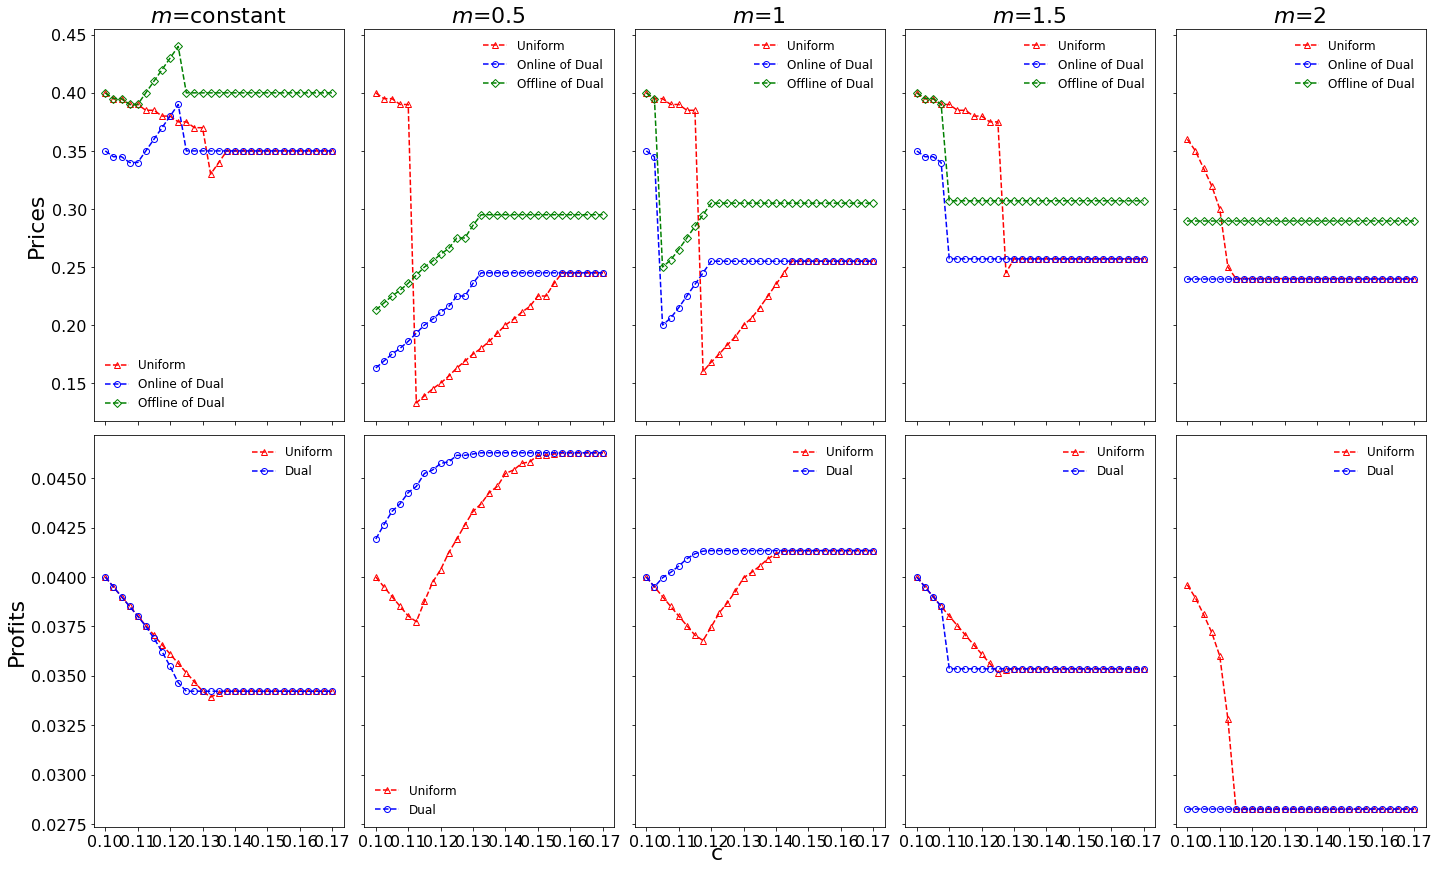

In [13]:
# ms = [2]
# filenames=["None"]
# main(ms, filenames, save=False, plot=True)


logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
ms = ["constant", 0.5, 1, 1.5, 2] 
filenames = []
for ind, m in enumerate(ms):
    filenames.append("file"+str(ind)+".xlsx")

cr = 0.32
con = 0.05
step = 0.001
density = 0.005
sel_c = np.arange(0.1, 0.17, 0.0025)
kernel="linear"
input_kwargs = {'cr': cr, 'con':con, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(ms=ms, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))
myfig = plot(data ,ms=ms, fz=(20,12))

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 39 seconds


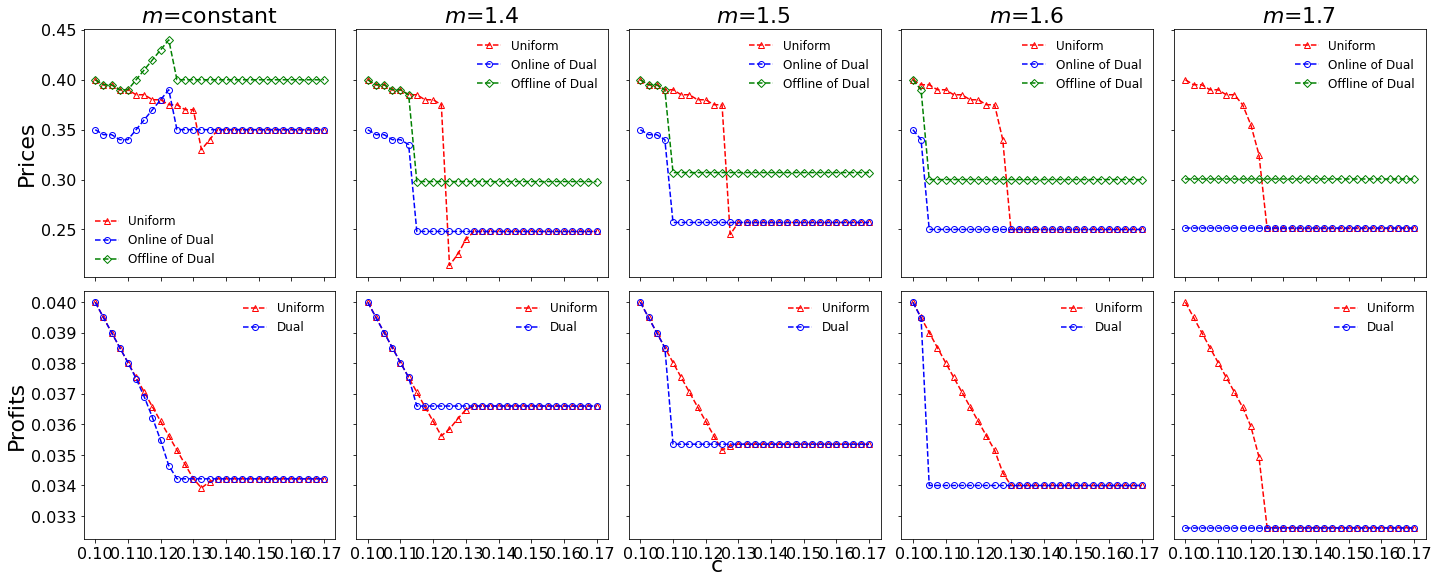

In [82]:
# ms = [2]
# filenames=["None"]
# main(ms, filenames, save=False, plot=True)


logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
ms = ["constant",1.4,1.5,1.6,1.7] 
filenames = []
for ind, m in enumerate(ms):
    filenames.append("file"+str(ind)+".xlsx")

cr = 0.32
con = 0.05
step = 0.001
density = 0.005
sel_c = np.arange(0.1, 0.17, 0.0025)
kernel="linear"
input_kwargs = {'cr': cr, 'con':con, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(ms=ms, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))

myfig = plot(data ,ms=ms, fz=(20,8))

In [83]:
cr = 0.32
con = 0.05
step = 0.001
density = 0.005
return_prop=2
c=0.11
kernel="linear"
dual_ins = dual(c=c, con=con, return_prop=return_prop, cr=cr, step=step, kernel=kernel, density=density)
pon=dual_ins.pon
print(pon)
gamma = get_return_probability(m=return_prop, pon=pon, kernel=kernel)
print(myround(c - 1 / 2 * con - 1 / 2 * (1 - gamma) * pon))
print("Online" if myround(c - 1 / 2 * con - 1 / 2 * (1 - gamma) * pon)>0 else 'offline')
demand = 1-(2*con+(1-gamma)*pon + pon)
print("demand: {}".format(demand))
print("profit: {},{}".format((1/2 * pon +1/2 *(1-gamma) *pon-1/2*gamma*cr)*demand *1/2, dual_ins.profit))

0.24000000000000002
0.022599999999999988
Online
demand: 0.5352
profit: 0.028258560000000002,0.028248000000000002


In [78]:
pon = 0.
gamma = get_return_probability(m=return_prop, pon=pon, kernel=kernel)
print(myround(c - 1 / 2 * con - 1 / 2 * (1 - gamma) * pon))
print("Online" if myround(c - 1 / 2 * con - 1 / 2 * (1 - gamma) * pon)>0 else 'offline')
demand = 1-(pon + 2*c +con)
print("demand: {}".format(demand))
print("profit: {}, {}".format((1/2 *(pon+con))*demand *1/2, dual_ins.profit))

0.024999999999999994
Online
demand: 0.42999999999999994
profit: 0.03762499999999999, 0.028248000000000002


##  A higher $c_{on}$ 

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 37 seconds


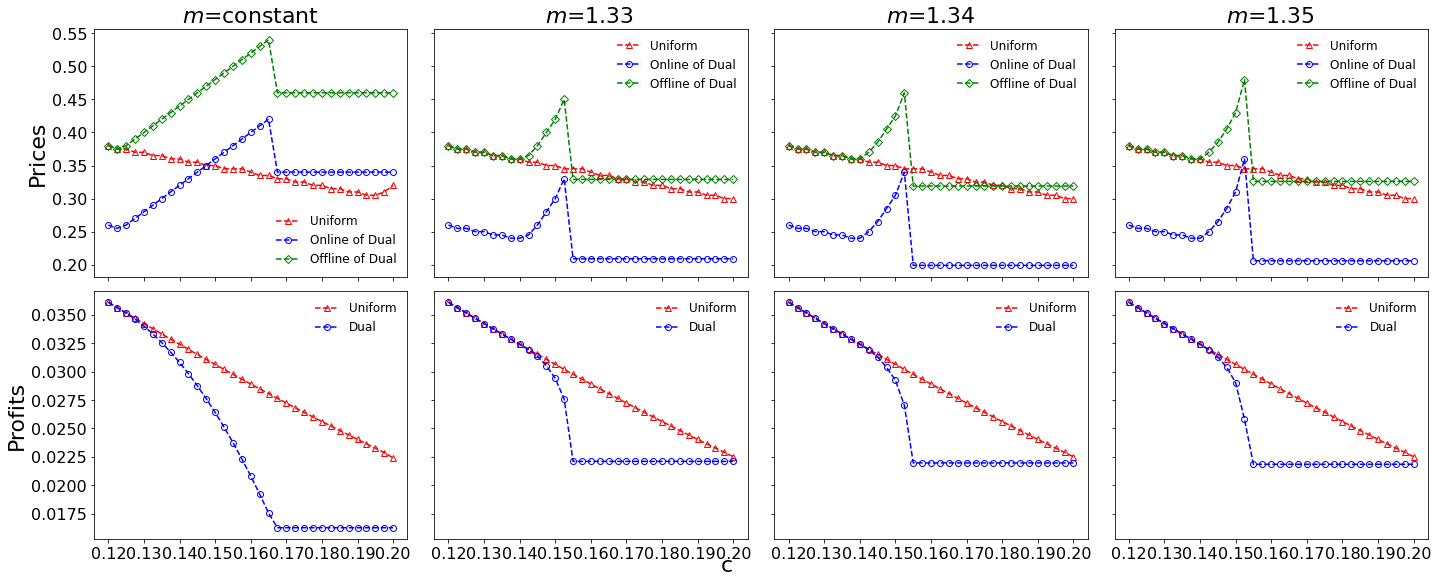

In [96]:
logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
ms = ["constant",1.33,1.34,1.35] 
filenames = []
for ind, m in enumerate(ms):
    filenames.append("file"+str(ind)+".xlsx")

cr = 0.5
con = 0.12
step = 0.001
density = 0.005
sel_c = np.arange(0.12, 0.2, 0.0025)
kernel="linear"
input_kwargs = {'cr': cr, 'con':con, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(ms=ms, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))

myfig = plot(data ,ms=ms, fz=(20,8))

##  return funciton is set as  SQRT

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 26 seconds


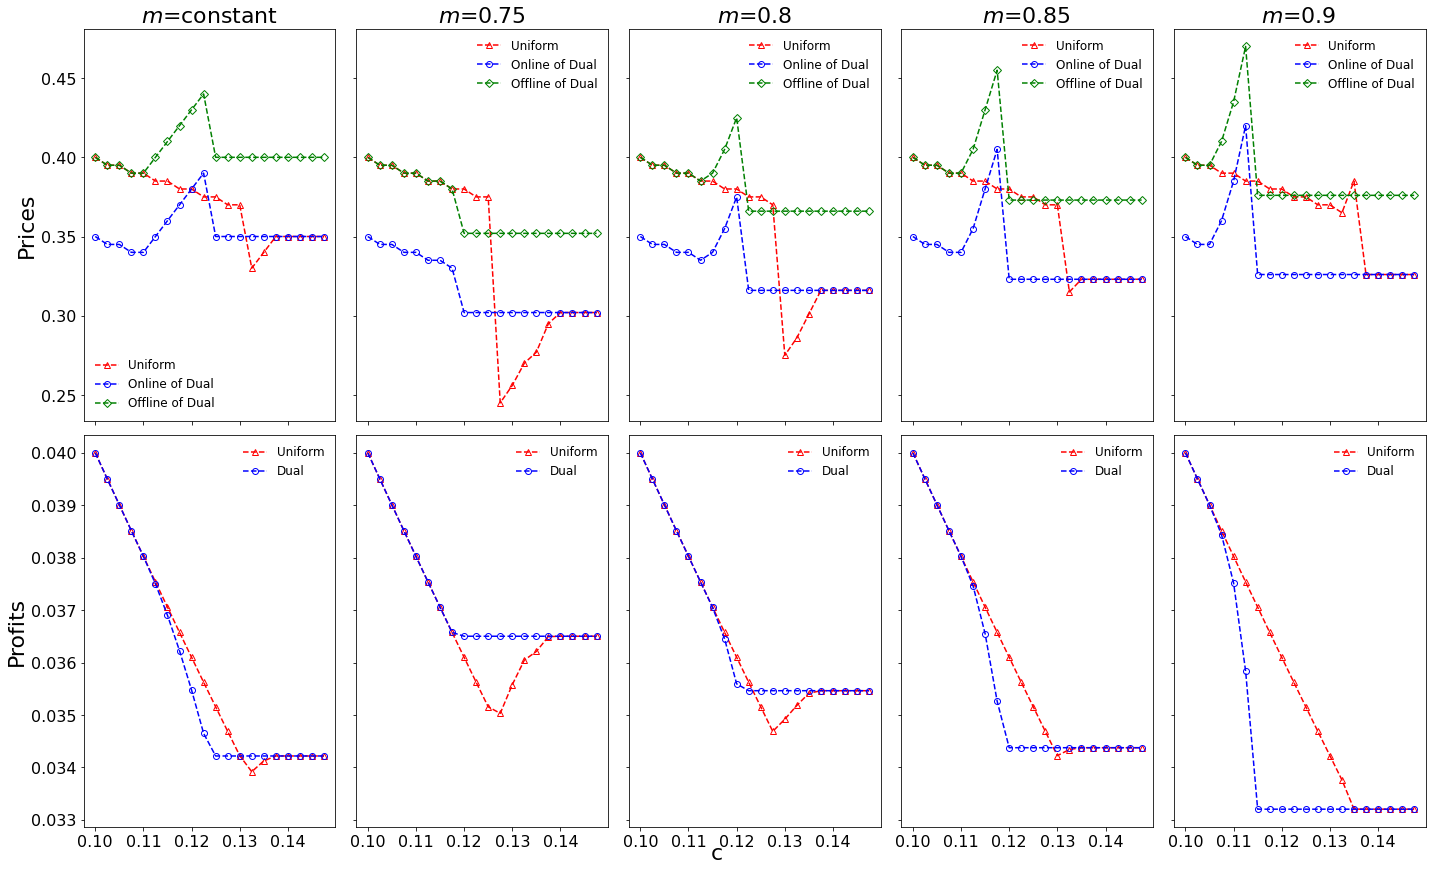

In [97]:
# ms = [2]
# filenames=["None"]
# main(ms, filenames, save=False, plot=True)


logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
ms = ["constant", 0.75, 0.8, 0.85,0.9] 
filenames = []
for ind, m in enumerate(ms):
    filenames.append("file"+str(ind)+".xlsx")

cr = 0.32
con = 0.05
step = 0.001
density = 0.005
sel_c = np.arange(0.1, 0.15, 0.0025)
kernel="sqrt"
input_kwargs = {'cr': cr, 'con':con, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(ms=ms, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))
myfig = plot(data ,ms=ms, fz=(20,12))

In [2]:
from scipy.stats import truncnorm

In [6]:
def cal_prop(p,mu, std):
    return (truncnorm.cdf(p, a=(0 - mu) / std, b=(1 - mu) / std, loc=mu, scale=std), 0.9 * p**(1/2))

In [20]:
print(cal_prop(p=0.43,mu=0.2,std=0.5))
print(cal_prop(p=0.25,mu=0.2,std=0.5))

(0.5538647971107306, 0.5901694671871801)
(0.32507872277561584, 0.45)


In [30]:
print(cal_prop(p=0.40,mu=0,std=0.49))
print(cal_prop(p=0.25,mu=0,std=0.49))

(0.6108977897856253, 0.5692099788303083)
(0.40688320550343504, 0.45)


In [28]:
print(cal_prop(p=0.4,mu=0,std=0.45))
print(cal_prop(p=0.25,mu=0,std=0.45))

(0.6428230661169759, 0.5692099788303083)
(0.43285565701694256, 0.45)
